In [1]:
import pandas as pd
import numpy as np
import igraph as ig
import tgm

## Data Format

The data consists of temporal 4- or 5-tuples:
* **(event_id, actor_id, time, root_id)**
* **(event_id, actor_id, time, root_id, parent_id)**

Where:
* event_id: is a unique id for each event
* actor_id: is the id of the actor/user generating the event
* time: in UTC format
* root_id: is the id of the root event that this event_id is part of
* parent_id: is the id of the parent of this event when events with same root_id have a tree structure

Assumption:
* event_id == root_id for the root event; in this case, parent_id is meaningless
* all events with same root_id can not happen before the root event itself (where event_id == root_id)
* if "parent_id" are used, the parent event can not happen before one of its child event


Example:
![](Images/events.png)


### Read sample data


In [2]:
df = pd.read_csv('../Data/sample.csv')
df.head()

,event_id,actor_id,time,root_id
0,t3_abct96,82f3169a255c,81,t3_abct96
1,t3_abcufh,7bdc2fb529b8,0,t3_abcufh
2,t3_abcufj,c89d9e2967ed,0,t3_abcufj
3,t3_abcufk,785ec5e2bbe,0,t3_abcufk
4,t3_abcufn,abdf350958da,1,t3_abcufn


### Finding K2h motifs

The function **K2h** is called to find temporal motifs. When called first, a DataFrame with the required columns needs to be passed. If the function is called several times for the same dataset (for example, trying different dt and dT parameters), then some speed-up can be achieved as we illustrate below.

##### Parameters:

* df: pandas DataFrame with the required columns:
 * **event_id**: unique id for each event
 * **actor_id**: a.k.a. userid
 * **time**: in seconds, typically UTC
 * **root_id**: id of the root event that this event_id is part of
* extras: list of extra columns to extract from 'df' and keep as attributes
* dt: reaction time for the motifs, in seconds
* dT: repetition time for the motifs, in seconds
* h: the 'h' in K2h, the number of different root_id's in the motifs (>=2)
* bg: bipartite graph obtained from a previous call of the 'K2h' function with the same dataframe 'df'; if supplied, 'df' is not required; this will speed-up the computation
* verbose: if set, return tuples of root_id's for each motif (default=False)
* return_df: if set, also output the results as a pandas DataFrame (default=False)
* return_bg: if set, output the bipartite graph that can be re-used for faster subsequent runs of 'K2h' (default=True)

Result are pairs of actors, the number of temporal motifs they share and if 'verbose' is set, the list of tuples of root_id's they share. 

##### Output:    
* self.graph: igraph Graph with K2h motifs
* self.df: pandas DataFrame with K2h motifs (optional, default=False)
* self.bg: igraph multi-bipartite Graph; can be used for faster subsequent runs of 'K2h' (optional, default=True)

For the DataFrame output, we also group the authors into weakly connected components, returning the component number for each one.


In [3]:
%%time
motifs = tgm.K2h(df=df, dt=300, dT=1800, h=2, return_df=True, verbose=True)

## result is returned as igraph Graph
print('number of motifs (graph):',motifs.graph.ecount())

## we also asked for DataFrame output
print('number of motifs (dataframe):', motifs.dataframe.shape[0])
motifs.dataframe.head()

number of motifs (graph): 66
number of motifs (dataframe): 66
CPU times: user 443 ms, sys: 10.6 ms, total: 454 ms
Wall time: 453 ms


,component,root,actor,count,list
0,0,db13efa89d39,2a40043e5eae,1,"[(t3_abdcho, t3_abdckj)]"
1,0,db13efa89d39,f412c03f8a90,1,"[(t3_abd9k4, t3_abdagb)]"
2,0,db13efa89d39,3c01aca59869,1,"[(t3_abd0ll, t3_abd9ew)]"
3,0,db13efa89d39,a1d984b645f4,2,"[(t3_abcwt1, t3_abcwuv), (t3_abcwuv, t3_abcwxn)]"
4,0,3f198de44ff8,f412c03f8a90,1,"[(t3_abd9k4, t3_abdagb)]"


### re-running given the bipartite graph from previous run

We use the bipartite graph from the previous run for faster (identical) results.


In [4]:
%%time
motifs = tgm.K2h(return_df=True, verbose=True, dt=300, dT=1800, h=2, bg=motifs.bipartite)
motifs.dataframe.head()

CPU times: user 228 ms, sys: 2.42 ms, total: 230 ms
Wall time: 230 ms


,component,root,actor,count,list
0,0,db13efa89d39,2a40043e5eae,1,"[(t3_abdcho, t3_abdckj)]"
1,0,db13efa89d39,f412c03f8a90,1,"[(t3_abd9k4, t3_abdagb)]"
2,0,db13efa89d39,3c01aca59869,1,"[(t3_abd0ll, t3_abd9ew)]"
3,0,db13efa89d39,a1d984b645f4,2,"[(t3_abcwt1, t3_abcwuv), (t3_abcwuv, t3_abcwxn)]"
4,0,3f198de44ff8,f412c03f8a90,1,"[(t3_abd9k4, t3_abdagb)]"


### Plot the resulting motif-based graph

The **prune_and_color** function can be called given the graph obtained from K2h to:
* color nodes as follows:
    * red: actors with root events only
    * blue: actors without root events
    * gold: actors with both types of events
* prune edges with respect to a specified **min_weight**, the minimum number of motifs required between actors
* prune nodes with respect to a specified **min_size**, the minimum size of weakly connected components to retain

We illustrate this below for the sample K2h-graph.


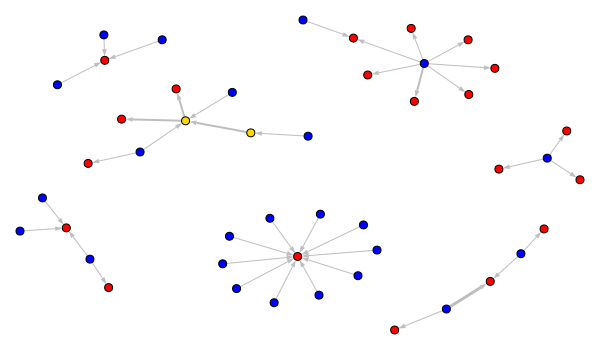

In [5]:
G = tgm.prune_and_color(motifs.graph, min_weight=1, min_size=3)
ig.plot(G, layout=G.layout_fruchterman_reingold(), vertex_size=8, bbox=(0,0,600,350), 
        edge_color='grey', edge_arrow_size=.5)